# Case Study📓: What impacts Car Price?


OVERVIEW

In this application, I will explore a dataset from kaggle that contains information on about 426,000 used cars. My goal is to understand what factors make a car more or less expensive. As a result of my analysis, I will provide clear recommendations to the client - a used car dealership - as to what consumers value in a used car.

By Liat Genosar Roth, BHMLAI

##  <font color= darkblue>Import Modules</font>

In [290]:
import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline

from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('fivethirtyeight') 

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.impute import KNNImputer

# For multiple regression
from sklearn.linear_model import LinearRegression

from datetime import datetime

# additional
import warnings
warnings.filterwarnings("ignore")
print("All modules uploaded")

# For extracting csv file from zip
import zipfile
import io
import requests

All modules uploaded


## Import Data

In [6]:
url = 'https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/practical_application_II_starter.zip'

# Download the ZIP file
response = requests.get(url)

# Extract CSV file
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    csv_file = zip_file.open('data/vehicles.csv')
    df_raw = pd.read_csv(csv_file)

##  <font color= darkred> Data Inspection</font>

**This dataset contains 17 features columns, one target columns - price,  and 426,880 entries.
Two columns can be removed, as they do not contribute to the car's price: id, and VIN.**
 - From the features columns, only year and odometer are numeric.

In [7]:
df_raw.shape
# This is a large dataset, with 426,880 entries (each entry is a used car record)
# The dataset has 18 features/columns. Some are numerical and some are categorical.

(426880, 18)

In [8]:
df_raw.head()
# There's a lot of NaN values in most of the dataset's columns
# Luckily this dataset is large enough to allow dropping entries with missing values.

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [9]:
df_raw.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
88044,7302223900,northwest CT,19000,1931.0,NaN,1931 model a pu truck wide body,excellent,4 cylinders,gas,100.0,clean,manual,NaN,rwd,NaN,pickup,blue,ct
331909,7306742166,lehigh valley,7495,2006.0,subaru,forester,NaN,4 cylinders,gas,75672.0,clean,automatic,JF1SG63616H730961,NaN,NaN,SUV,white,pa
326546,7311734944,salem,10995,2014.0,ford,fusion,NaN,NaN,gas,97433.0,clean,automatic,3FA6P0LU8ER286486,NaN,NaN,sedan,red,or
279002,7311482303,rochester,6200,2003.0,ford,ranger xlt,good,6 cylinders,gas,109000.0,clean,automatic,NaN,4wd,mid-size,NaN,red,ny
29880,7316851677,inland empire,5500,1999.0,toyota,tacoma,good,4 cylinders,gas,200088.0,clean,automatic,NaN,rwd,NaN,pickup,white,ca


In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

Target column is price

In [147]:
df_raw.select_dtypes("object").describe()

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426880
unique,404,42,29649,6,8,5,6,3,118246,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,50614


**Removing Columns that do not affect the car price: id, VIN.**

In [202]:
df = df_raw.drop(columns=['id', 'VIN'], axis=1)
df.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

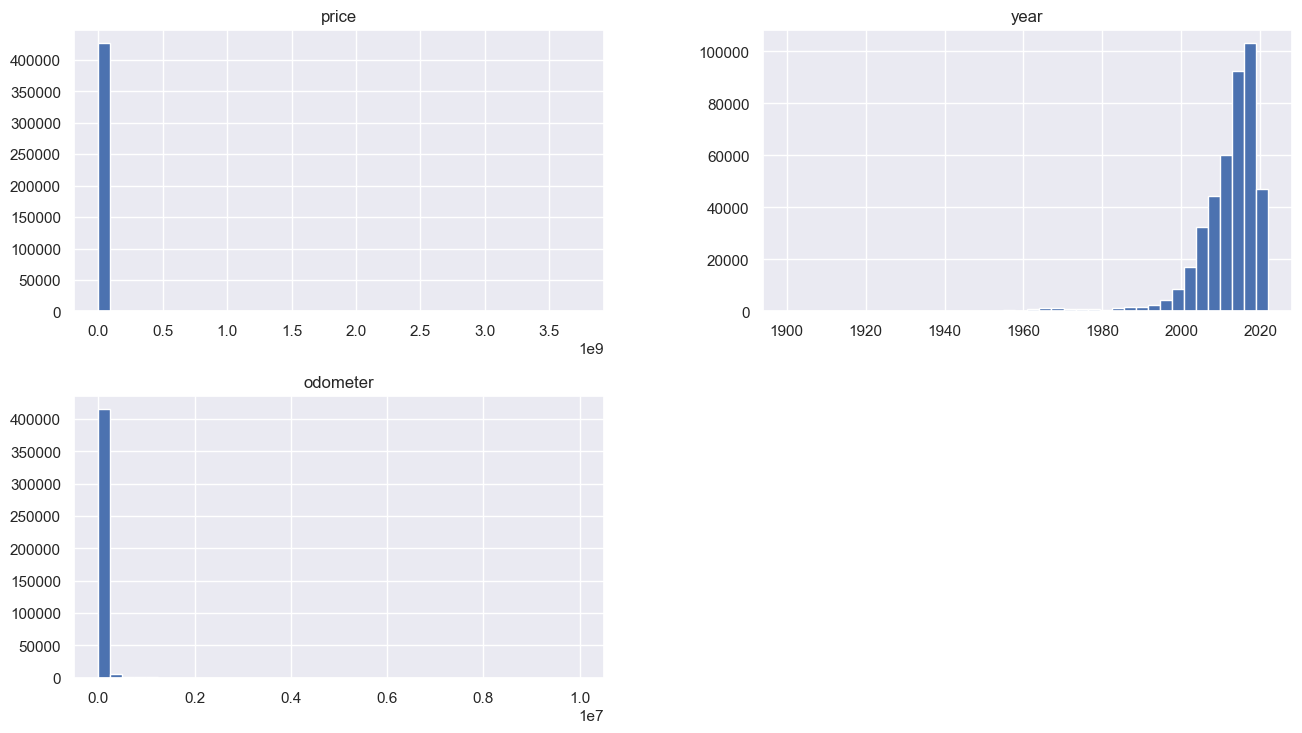

In [203]:
df.hist(bins = 40,figsize = (14,8));

A lot of zero values in odometer and price columns. Year col. has outliers that shift the histogram to the right.

In [204]:
df.describe()

,price,year,odometer
count,4.268800e+05,425675.000000,4.224800e+05
mean,7.519903e+04,2011.235191,9.804333e+04
std,1.218228e+07,9.452120,2.138815e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2008.000000,3.770400e+04
50%,1.395000e+04,2013.000000,8.554800e+04
75%,2.648575e+04,2017.000000,1.335425e+05
max,3.736929e+09,2022.000000,1.000000e+07


In [205]:
df.isna().mean().round(4)*100

region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64

Missing (NaN) Values: 6 columns have sizeable portion of missing values of over 20%: condition (40%), cylinders (41.6%), drive, size (71.8%), type, and paint_color. 

I consider dropping size feature (71.8% missing values), especialy that it might correlate with typr feature. 

#  <font color= darkred>EDA, Data Cleaning & Filling Missing Values </font>

###  <font color= darkblue> Price (target column), Exploration and Outliers Cleaning</font>

In [206]:
df.price.median()

13950.0

In [207]:
p = [0.05, 0.25, 0.85, 0.95, 0.99]
df[['price']].describe(p)

,price
count,4.268800e+05
mean,7.519903e+04
std,1.218228e+07
min,0.000000e+00
5%,0.000000e+00
25%,5.900000e+03
50%,1.395000e+04
85%,3.299500e+04
95%,4.450000e+04
99%,6.699500e+04


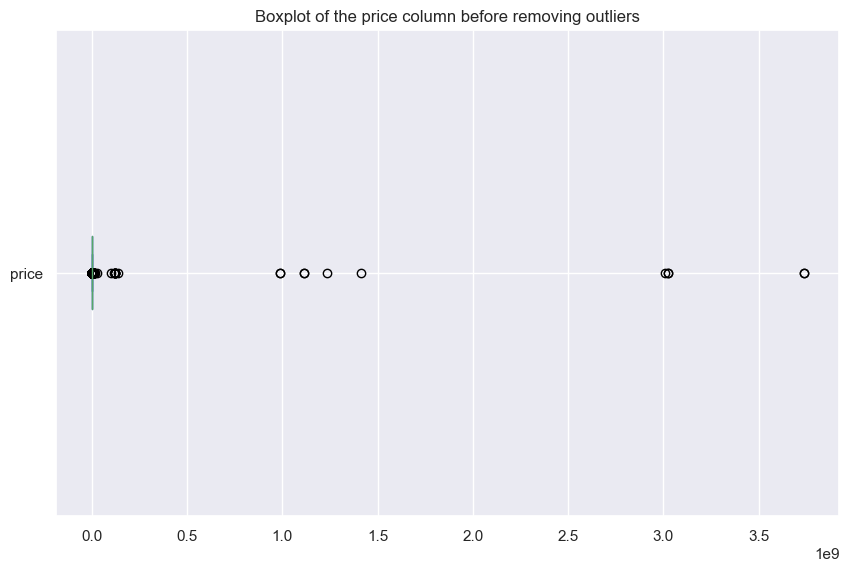

In [208]:
df['price'].plot(kind = 'box', vert = False, title = "Boxplot of the price column before removing outliers");

**The price column:** there are outliers, including a lot of entries with zero values that will be removed (32,895).
The model will not take care of used cars with zero value. Mean value is 75,199.03 USD 
while the median price is \$13,950.
Max value is 7.317101e+09 USD - which is 7.3 Billion dollars ! which doesn't make sense either for a used car price (unless it is something very rare, outside the scope of the model).
those entries on the billion dollar side, skew the mean value to the right.

In [209]:
df['price'].value_counts()

0        32895
6995      3169
7995      3129
9995      2867
8995      2837
         ...  
21298        1
49217        1
63195        1
19709        1
17873        1
Name: price, Length: 15655, dtype: int64

In [210]:
bins = [0, 3000, 6000, 10000, 14000, 18000, 22000, 26000, 30000,50000,100000,200000,500000,3800000000]
labels=['0-3000','3000-6000','6k-10k','10k-14k','14k-18k','18k-22k','22k-26k','26k-30k',
        '30k-50k','50k-100k','100k-200k','200k-500k','500k-3.8x10^9']

df['price_bins'] = pd.cut(df['price'], bins=bins, labels=labels, right=False)
print(df['price_bins'].value_counts())

30k-50k          66199
0-3000           63816
6k-10k           62294
3000-6000        48854
10k-14k          42817
14k-18k          41410
18k-22k          31989
22k-26k          28421
26k-30k          28039
50k-100k         12344
100k-200k          570
500k-3.8x10^9       68
200k-500k           59
Name: price_bins, dtype: int64


**I will use z-score (stats module), to calculate the z-score of the `price` colum and clean entries with price outliers.** 
This is done by taking the absolute zscore values and throwing out any value greater than 3.

In [211]:
df_z = df[np.abs(stats.zscore(df['price'])) < 3].copy()
df_z.shape

(426860, 17)

Only 20 entries were dropped using z-score.
Now I'll drop zero values, the lower 2%, and the uper values over 200,000 USD. This high limit is even over the 99.5% percentile, and reflects what I assume as an upper reasonable price for a used car.

In [212]:
df = df_z.copy()
# Dropping enries with price = 0
df.drop(index=df[df['price'] == 0].index, inplace=True)
df.shape

(393965, 17)

In [213]:
p = [0.02,0.05, 0.85, 0.50, 0.95, 0.99, 0.995]
df[['price']].describe(p)

,price
count,3.939650e+05
mean,1.938320e+04
std,7.585618e+04
min,1.000000e+00
2%,3.960000e+02
5%,1.988000e+03
50%,1.500000e+04
85%,3.399400e+04
95%,4.499900e+04
99%,6.849680e+04


In [214]:
# 200,000$ will be the upper limit for a used car price, $396 will be the lower limit 
df.drop(index=df[df['price'] > 200000].index, inplace=True)
df.drop(index=df[df['price'] < 150].index, inplace=True)
df.shape

(389937, 17)

In [215]:
df.price.describe()

count    389937.000000
mean      19055.861860
std       15049.400041
min         150.000000
25%        7499.000000
50%       15555.000000
75%       27921.000000
max      200000.000000
Name: price, dtype: float64

**Before the preliminary removal of outliers, price std was 1.218228e+07 1,218,228 USD, and now it is \$15,049.4, significantly lower by 3 orders of magnitude.**

Text(0.5, 1.0, 'Car price values distribution after cleaning outliers')

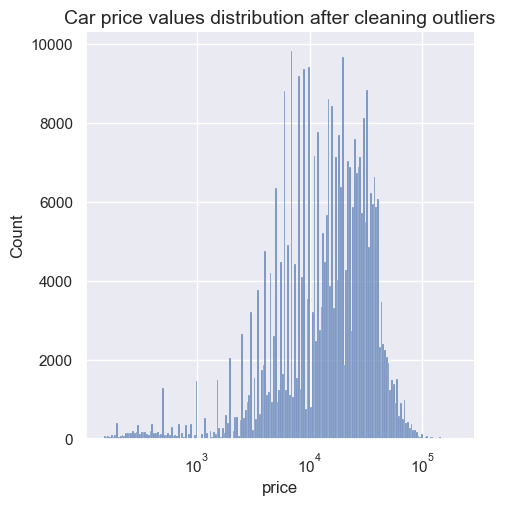

In [216]:
sns.displot(data=df, x='price', log_scale=True)
plt.title("Car price values distribution after cleaning outliers",fontsize=14)

After cleaning outliers, the price distribution (on the log scale), looks less skewed.

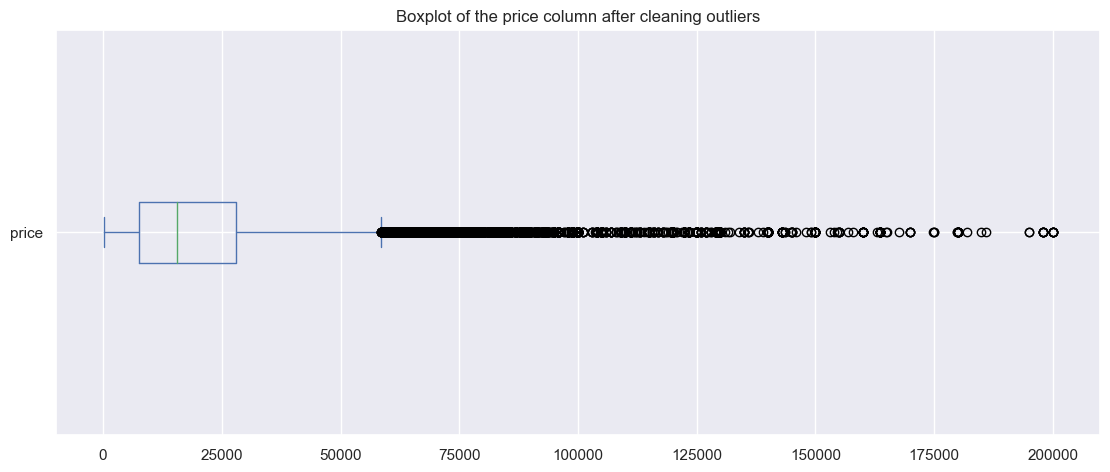

In [217]:
plt.rcParams["figure.figsize"] = (12,5)
df['price'].plot(kind = 'box', vert = False, title = "Boxplot of the price column after cleaning outliers");

In [218]:
# Checking again for NA status
df.isna().mean().round(4)*100

region           0.00
price            0.00
year             0.30
manufacturer     4.05
model            1.17
condition       38.27
cylinders       40.64
fuel             0.67
odometer         0.58
title_status     1.96
transmission     0.47
drive           30.47
size            72.06
type            21.59
paint_color     29.56
state            0.00
price_bins       0.00
dtype: float64

## Exploring Numeric Features: Year, Odometer
##  <font color= darkblue> Year </font>
**How old are the used cars in the dataset, and how are the values distributed:**

Text(0.5, 1.0, 'Year values distribution')

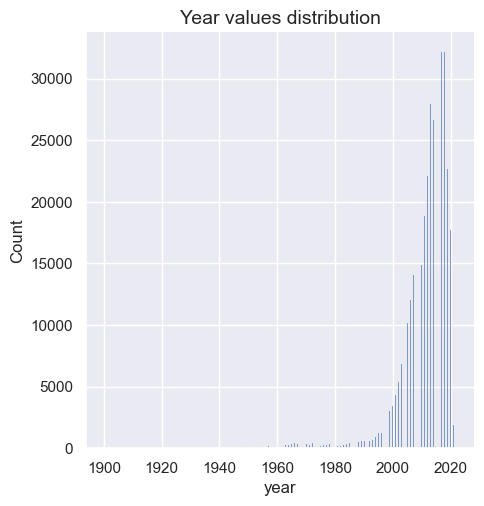

In [219]:
sns.displot(data=df, x='year', log_scale=False)
plt.title("Year values distribution",fontsize=14)

'year' values are not evenly distributed, the distribution is skewed to the right.

In [220]:
p = [0.05, 0.10, 0.25, 0.50, 0.75, 0.95]
df[['year']].describe(p)

,year
count,388764.000000
mean,2011.020411
std,9.567298
min,1900.000000
5%,1998.000000
10%,2003.000000
25%,2008.000000
50%,2013.000000
75%,2017.000000
95%,2020.000000


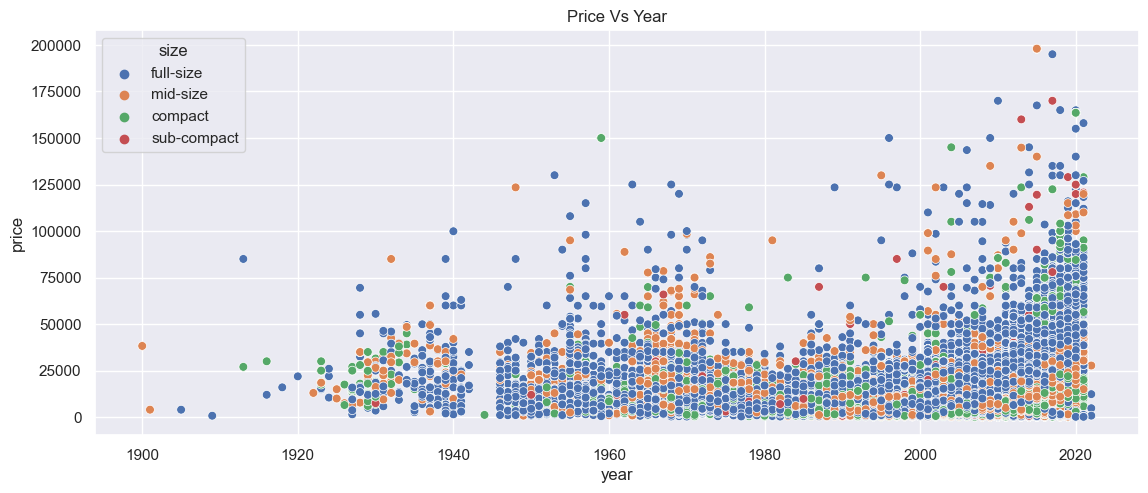

In [221]:
plt.xlabel("year")
plt.ylabel("price")
plt.title("Price Vs Year")
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(data=df, x='year', y='price', s=40, hue='size');  

Price correlates with the year of manufacturing, but not linearly.
Antique/classic/vintage cars have pricing of their own. Old cars might have their own set of rules, but I will keep them in the daaset as they correlate with the price.

Text(0.5, 1.0, 'Year values distribution 1970-2020')

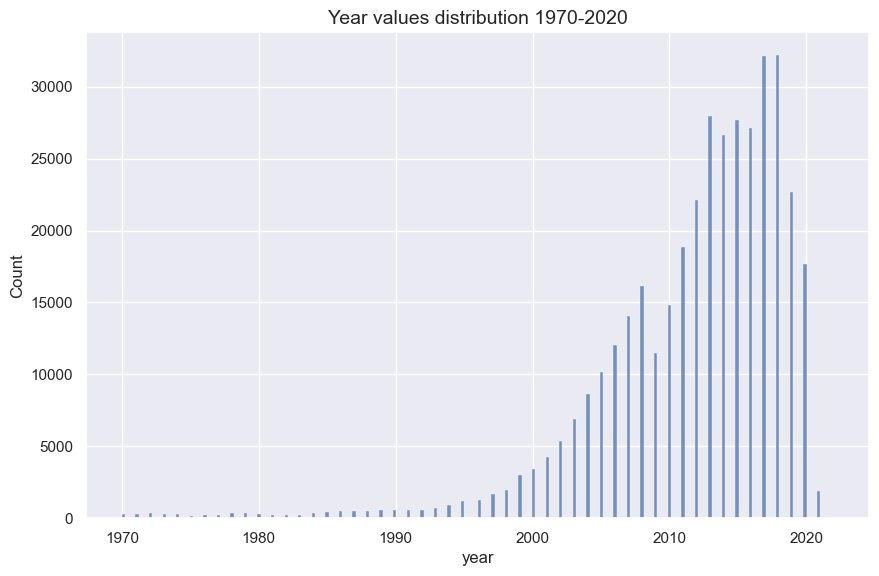

In [224]:
sns.set(rc={'figure.figsize':(9,6)})
sns.histplot(data=(df[df['year'] >= 1970]), x='year')
plt.title("Year values distribution 1970-2020",fontsize=14)

##  <font color= darkblue> Odometer</font>

In [225]:
df.odometer.describe()

count    3.876610e+05
mean     9.842724e+04
std      1.979784e+05
min      0.000000e+00
25%      3.800000e+04
50%      8.704800e+04
75%      1.356550e+05
max      1.000000e+07
Name: odometer, dtype: float64

In [226]:
# year had 1.03% missing values

df.dropna(subset=['odometer'], inplace=True)

Text(0.5, 1.0, 'Odometer values distribution')

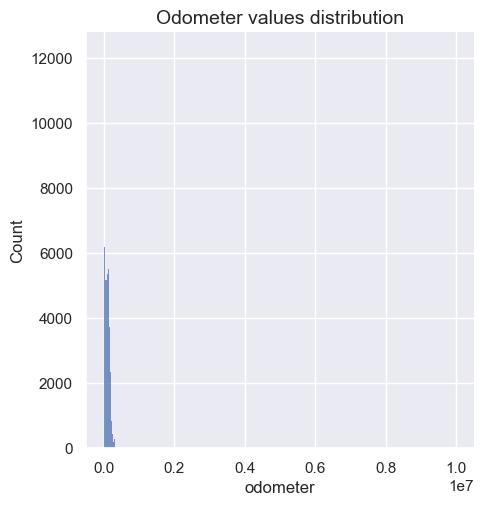

In [227]:
sns.displot(data=df, x='odometer', log_scale=False)
plt.title("Odometer values distribution",fontsize=14)

Text(0.5, 1.0, 'Odometer > 0 values distribution')

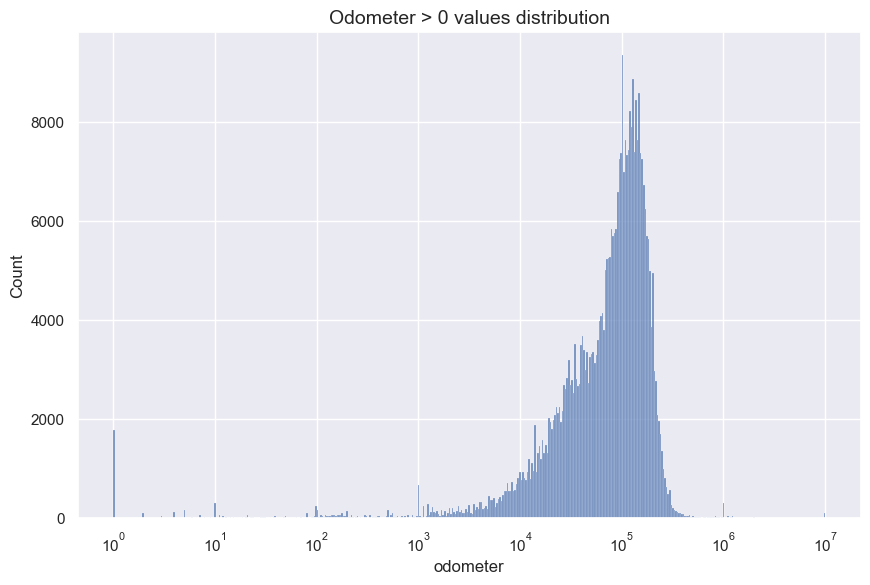

In [228]:
sns.histplot(data=(df[df['odometer'] > 0]), x='odometer', log_scale=True)
plt.title("Odometer > 0 values distribution",fontsize=14)

I will leave outliers. As new used cars might have zero value on the odometer, and very old cars might have huge milage.

#  <font color= darkblue> Categorical Features : Exploring, Data Cleaning, and Engineering</font>

###  <font color= darkblue> manufacturer, model, fuel, title_status, and transmission columns</font>
**Remove missing values from manufacturer, model, fuel, odometer, title_status, and transmission columns.**
For those columns, missing values are about 4% and less, and the dataset is large enough to allow droping them.

In [229]:
dropna_subset = ['manufacturer','model','fuel','title_status','transmission']
df.dropna(subset=dropna_subset, inplace=True)

In [230]:
df.shape

(357629, 17)

## Condition feature

In [231]:
# condition col. has 38.27% missing values.
# Since 50% of condition unique values is 'good', I will fill missing values using it.
df['condition'].value_counts(normalize=True)

good         0.508318
excellent    0.373813
like new     0.084812
fair         0.026372
new          0.004337
salvage      0.002347
Name: condition, dtype: float64

In [232]:
df.condition = df.condition.fillna('good')

In [233]:
df.isna().mean().round(4)*100

region           0.00
price            0.00
year             0.00
manufacturer     0.00
model            0.00
condition        0.00
cylinders       40.74
fuel             0.00
odometer         0.00
title_status     0.00
transmission     0.00
drive           29.64
size            71.57
type            21.22
paint_color     28.09
state            0.00
price_bins       0.00
dtype: float64

##  <font color= darkblue> size feature (72% missing values) and type feature (21% mising) </font>
I expect those columns to be correlated with each other.

In [234]:
# size column has 71.6% missing values
df['size'].value_counts(normalize=True)

full-size      0.523182
mid-size       0.297132
compact        0.154595
sub-compact    0.025090
Name: size, dtype: float64

In [235]:
# type col. has '21% missing values 
df['type'].value_counts(normalize=True)

sedan          0.263036
SUV            0.230806
pickup         0.138251
truck          0.096973
other          0.064068
coupe          0.057072
hatchback      0.050691
wagon          0.033072
van            0.024568
convertible    0.023308
mini-van       0.015262
offroad        0.001874
bus            0.001019
Name: type, dtype: float64

In [236]:
df.groupby('size')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
size,,,,,,,,
compact,15718.0,11323.745706,9252.073556,150.0,5200.0,8900.0,14995.0,150000.0
full-size,53193.0,16619.215893,13710.639832,150.0,6500.0,12695.0,23500.0,195000.0
mid-size,30210.0,12407.202185,10107.566654,166.0,5400.0,9480.0,16995.0,144832.0
sub-compact,2551.0,12881.389651,12265.095864,175.0,5800.0,8999.0,16497.0,169999.0


(array([0, 1, 2, 3]),
 [Text(0, 0, 'compact'),
  Text(1, 0, 'full-size'),
  Text(2, 0, 'mid-size'),
  Text(3, 0, 'sub-compact')])

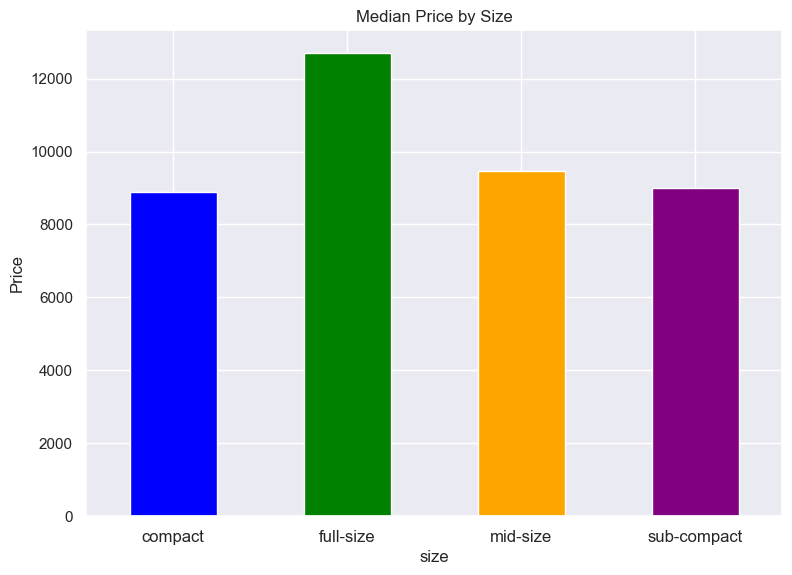

In [237]:
colors = ['blue','green','orange','purple']
df.groupby('size')['price'].median().plot(kind='bar',title='Median Price by Size', color=colors, figsize=(8, 6));
plt.ylabel("Price")
plt.xticks(rotation=0, fontsize=12)

Compact, mid-size and sub-compact car types have a very similar median price. Full-sized cars have a median price higher by around $2500.

**type feature and price values distribution:**

In [238]:
df.groupby('type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
SUV,65029.0,17707.409863,12849.120679,151.0,7995.00,14990.0,24990.0,195000.0
bus,287.0,14762.059233,9067.917893,175.0,7500.00,13900.0,22950.0,50427.0
convertible,6567.0,21010.973352,18168.840786,161.0,8995.00,16500.0,26999.0,153880.0
coupe,16080.0,23063.877239,16960.609172,154.0,9800.00,20990.0,33990.0,179999.0
hatchback,14282.0,15497.741003,9685.642200,150.0,7300.50,14984.0,20990.0,98995.0
mini-van,4300.0,9773.507674,8092.700641,199.0,4299.00,7495.0,12995.0,79900.0
offroad,528.0,16466.823864,11819.046456,500.0,7971.25,13000.0,23388.0,60000.0
other,18051.0,27308.588555,12974.749688,155.0,17995.00,27995.0,35590.0,159991.0
pickup,38952.0,28670.354667,14410.152229,187.0,19239.00,28488.0,36000.0,135900.0


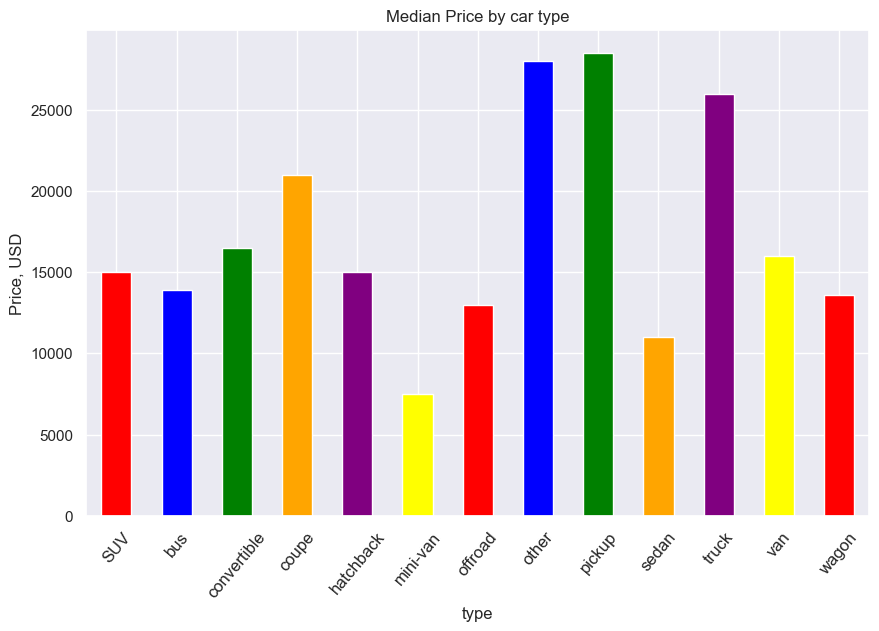

In [239]:
cmap = cm.get_cmap('Spectral') # Color map
colors = ['red','blue','green','orange','purple','yellow','red','blue','green','orange','purple','yellow','red']
df.groupby('type')['price'].median().plot(kind='bar',title='Median Price by car type', cmap=cmap, color=colors)
plt.ylabel('Price, USD')
plt.xticks(rotation=50, fontsize=12);

size column has a lot of missing values (~70%), together with the understanding that type column gives similar information about a car, but more nuanced, if you look at the distribution of median car price per type - it makes a lot of sense to drop the size column from the dataset.

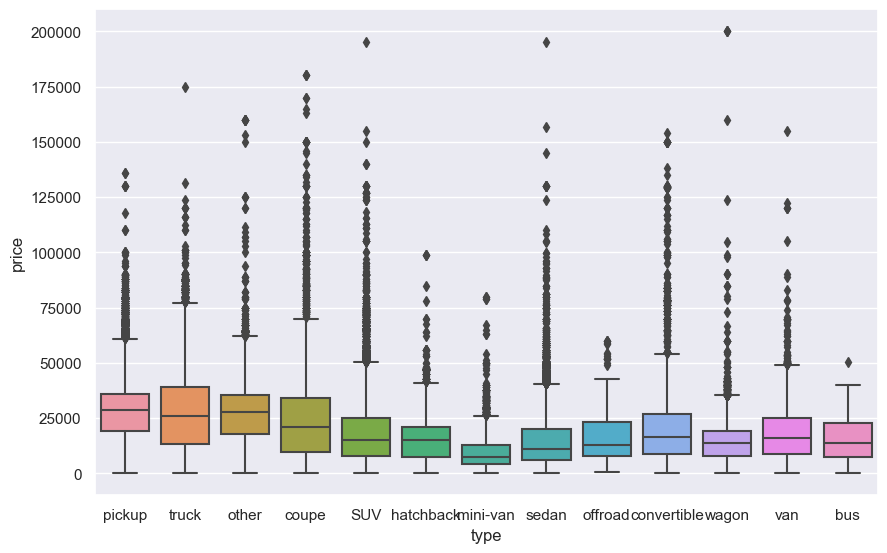

In [240]:
sns.boxplot(data=df, x='type', y='price');

The majority of used cars prices (75%) of all types is bellow 50,000 USD. Convertible, trucks, other, and pickup are among used cars types that reach median price over 20,000 and over 25,000 USD, while all other car types median prices are around \$15,000.

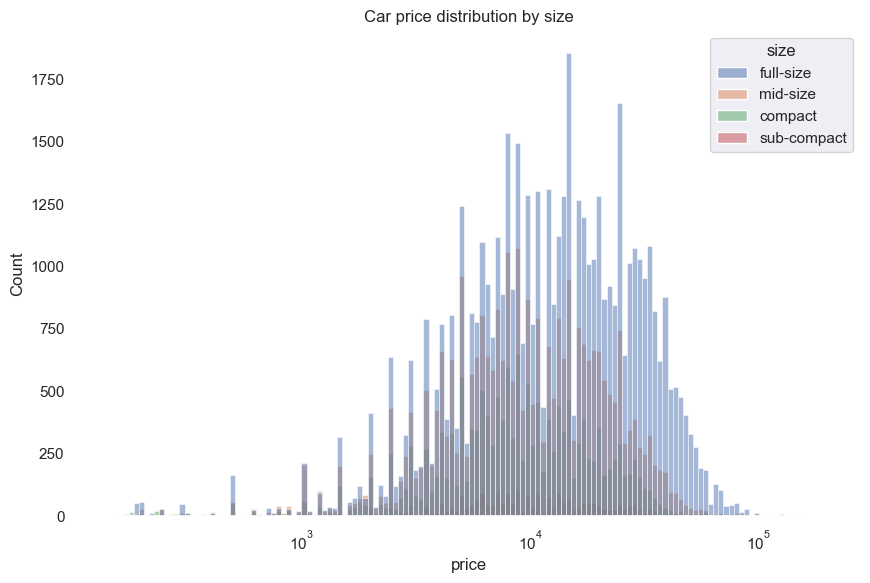

In [241]:
sns.histplot(data=df, x='price', hue='size', log_scale=True)
plt.title("Car price distribution by size",fontsize=12)
plt.gca().set_zorder(4) # To bring hue to the front
plt.gca().patch.set_facecolor('white')
plt.gca().patch.set_alpha(0)
plt.show()

In [242]:
df['type'].value_counts()

sedan          74110
SUV            65029
pickup         38952
truck          27322
other          18051
coupe          16080
hatchback      14282
wagon           9318
van             6922
convertible     6567
mini-van        4300
offroad          528
bus              287
Name: type, dtype: int64

In [243]:
df['type'].value_counts(normalize= True)

sedan          0.263036
SUV            0.230806
pickup         0.138251
truck          0.096973
other          0.064068
coupe          0.057072
hatchback      0.050691
wagon          0.033072
van            0.024568
convertible    0.023308
mini-van       0.015262
offroad        0.001874
bus            0.001019
Name: type, dtype: float64

In [244]:
df['type'].value_counts(normalize= True, dropna=False)

NaN            0.212178
sedan          0.207226
SUV            0.181834
pickup         0.108917
truck          0.076398
other          0.050474
coupe          0.044963
hatchback      0.039935
wagon          0.026055
van            0.019355
convertible    0.018363
mini-van       0.012024
offroad        0.001476
bus            0.000803
Name: type, dtype: float64

The most frequent tyoe is **sedan** - 26% of total cars in the dataset.

In [245]:
df['size'].value_counts(normalize=True)

full-size      0.523182
mid-size       0.297132
compact        0.154595
sub-compact    0.025090
Name: size, dtype: float64

In [246]:
df['size'].value_counts(normalize=True, dropna=False)
# This are the actual percentages of car sizes out of the totals in the dataset, since so many are missing.

NaN            0.715705
full-size      0.148738
mid-size       0.084473
compact        0.043951
sub-compact    0.007133
Name: size, dtype: float64

**type and size crosstab**

In [247]:
pd.crosstab(df['size'],df['type'], normalize='index').round(2).style.format('{:.2%}')

type,SUV,bus,convertible,coupe,hatchback,mini-van,offroad,other,pickup,sedan,truck,van,wagon
size,,,,,,,,,,,,,
compact,13.00%,0.00%,6.00%,12.00%,15.00%,0.00%,0.00%,1.00%,3.00%,41.00%,1.00%,1.00%,6.00%
full-size,25.00%,0.00%,1.00%,2.00%,1.00%,3.00%,0.00%,1.00%,14.00%,22.00%,25.00%,5.00%,1.00%
mid-size,35.00%,0.00%,3.00%,6.00%,4.00%,2.00%,0.00%,0.00%,3.00%,38.00%,4.00%,1.00%,3.00%
sub-compact,8.00%,0.00%,15.00%,27.00%,19.00%,1.00%,0.00%,1.00%,1.00%,25.00%,1.00%,0.00%,2.00%


**filling type column missing values according to its correlation with size column. size column will be dropped since it has a very high rate of mising values (71.6%), and a similar information is given by type column (co-linearity of features).**
From the size-type crosstab table there is not enough decisive percentages of types per size tp fill in size column according to type col.

In [248]:
df.loc[df["size"] == "compact", "type"] = df["type"].fillna('sedan')

In [249]:
df.loc[df["size"] == "full-size", "type"] = df["type"].fillna('SUV')

In [250]:
df.loc[df["size"] == "mid-size", "type"] = df["type"].fillna('SUV')

In [251]:
df.loc[df["size"] == "sub-compact", "type"] = df["type"].fillna('coupe')

In [252]:
df.isna().mean().round(4)*100

region           0.00
price            0.00
year             0.00
manufacturer     0.00
model            0.00
condition        0.00
cylinders       40.74
fuel             0.00
odometer         0.00
title_status     0.00
transmission     0.00
drive           29.64
size            71.57
type            20.40
paint_color     28.09
state            0.00
price_bins       0.00
dtype: float64

In [253]:
dropna_subset = ['type']
df.dropna(subset=dropna_subset, inplace=True)

**Drop size column, because it has 72% missing values. Size is co-linear with type column, so we will still have size-related information.**
Another reason is that bot size and type are correlated with the price, but type is more nuanced.

In [254]:
df = df.drop(columns=['size'], axis=1)
df.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state', 'price_bins'],
      dtype='object')

In [255]:
# Number of entries now dropped to ~285,000. Still big enough set for a multiple regression model.
df.shape

(284676, 16)

In [256]:
df.isna().mean().round(4)*100

region           0.00
price            0.00
year             0.00
manufacturer     0.00
model            0.00
condition        0.00
cylinders       32.95
fuel             0.00
odometer         0.00
title_status     0.00
transmission     0.00
drive           20.34
type             0.00
paint_color     16.57
state            0.00
price_bins       0.00
dtype: float64

##  <font color= darkblue> Cylinders Feature: </font>
**Fill missing values in cylinders column**. Values here won't be changed to numeric because it is not ordinal.

In [196]:
df['cylinders'].value_counts(normalize=True)

6 cylinders     0.386606
4 cylinders     0.313738
8 cylinders     0.281917
5 cylinders     0.006905
10 cylinders    0.004490
other           0.003557
3 cylinders     0.002326
12 cylinders    0.000461
Name: cylinders, dtype: float64

In [195]:
pd.crosstab(df['type'],df['cylinders'], normalize='index').round(2).style.format('{:.2%}')

cylinders,10 cylinders,12 cylinders,3 cylinders,4 cylinders,5 cylinders,6 cylinders,8 cylinders,other
type,,,,,,,,
SUV,0.00%,0.00%,0.00%,32.00%,0.00%,50.00%,18.00%,0.00%
bus,30.00%,0.00%,0.00%,20.00%,0.00%,8.00%,42.00%,0.00%
convertible,0.00%,0.00%,0.00%,23.00%,1.00%,36.00%,39.00%,1.00%
coupe,0.00%,0.00%,0.00%,23.00%,0.00%,31.00%,44.00%,1.00%
hatchback,0.00%,0.00%,2.00%,86.00%,2.00%,7.00%,2.00%,2.00%
mini-van,0.00%,0.00%,0.00%,8.00%,0.00%,91.00%,1.00%,0.00%
offroad,0.00%,0.00%,0.00%,16.00%,1.00%,61.00%,22.00%,0.00%
other,0.00%,0.00%,0.00%,13.00%,0.00%,63.00%,23.00%,0.00%
pickup,0.00%,0.00%,0.00%,3.00%,0.00%,37.00%,59.00%,0.00%


The way to fill in missing cylinders values is by the percentages shown in the crosstab with type table. 6 cylinders is the majority in: SUV, convertible, mini-van, offroad, other, and van. Types with 4 cylinders: hatchback, sedan and wagon. 

In [257]:
df.loc[df["type"] == "hatchback", "cylinders"] = df["cylinders"].fillna("4 cylinders")
df.loc[df["type"] == "sedan", "cylinders"] = df["cylinders"].fillna("4 cylinders")
df.loc[df["type"] == "wagon", "cylinders"] = df["cylinders"].fillna("4 cylinders")
df.loc[df["type"] == "SUV", "cylinders"] = df["cylinders"].fillna("6 cylinders")
df.loc[df["type"] == "convertible", "cylinders"] = df["cylinders"].fillna("6 cylinders")
df.loc[df["type"] == "mini-van", "cylinders"] = df["cylinders"].fillna("6 cylinders")
df.loc[df["type"] == "offroad", "cylinders"] = df["cylinders"].fillna("6 cylinders")
df.loc[df["type"] == "other", "cylinders"] = df["cylinders"].fillna("6 cylinders")
df.loc[df["type"] == "van", "cylinders"] = df["cylinders"].fillna("6 cylinders")
df.loc[df["type"] == "convertible", "cylinders"] = df["cylinders"].fillna("8 cylinders")
df.loc[df["type"] == "bus", "cylinders"] = df["cylinders"].fillna("8 cylinders")
df.loc[df["type"] == "coupe", "cylinders"] = df["cylinders"].fillna("8 cylinders")
df.loc[df["type"] == "pickup", "cylinders"] = df["cylinders"].fillna("8 cylinders")
df.loc[df["type"] == "truck", "cylinders"] = df["cylinders"].fillna("8 cylinders")

#mask = ~df.loc[df.query('type in @cylinders_4')]
# I could not figure out how to make it in a more elegant way using mask, or to query type in a list of types

In [259]:
df.isna().mean().round(4)*100
# Now all the missing values in cylinders are filled.

region           0.00
price            0.00
year             0.00
manufacturer     0.00
model            0.00
condition        0.00
cylinders        0.00
fuel             0.00
odometer         0.00
title_status     0.00
transmission     0.00
drive           20.34
type             0.00
paint_color     16.57
state            0.00
price_bins       0.00
dtype: float64

In [260]:
df.cylinders.describe()

count          284676
unique              8
top       6 cylinders
freq           106150
Name: cylinders, dtype: object

In [261]:
df.cylinders.value_counts()

6 cylinders     106150
4 cylinders      97561
8 cylinders      77579
5 cylinders       1318
10 cylinders       857
other              679
3 cylinders        444
12 cylinders        88
Name: cylinders, dtype: int64

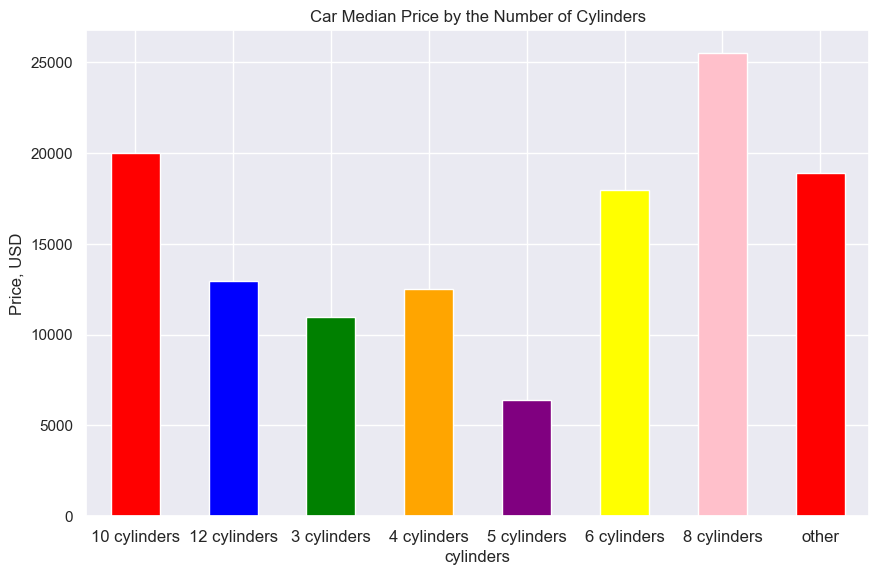

In [262]:
colors = ['red','blue','green','orange','purple','yellow','pink']
df.groupby('cylinders')['price'].median().plot(kind='bar',title='Car Median Price by the Number of Cylinders', cmap=cmap, color=colors)
plt.ylabel('Price, USD')
plt.xticks(rotation=0, fontsize=12);

**Number of Cylinders and Median Price:** 8, 10 and 6 cylinders are at the top of median prices. 8 cylinders group contains: buses, convertible, coupe, pickup, and trucks in high share percentages, so it is now onder their median price is at the top.

##  <font color= darkblue> Drive Feature: </font>
**Filling missing values**

In [263]:
df['drive'].value_counts(dropna=False)

4wd    98887
fwd    83576
NaN    57903
rwd    44310
Name: drive, dtype: int64

In [264]:
pd.crosstab(df['type'],df['drive'], normalize='index').round(2).style.format('{:.3%}')

drive,4wd,fwd,rwd
type,,,
SUV,69.000%,24.000%,7.000%
bus,4.000%,16.000%,79.000%
convertible,7.000%,20.000%,73.000%
coupe,4.000%,26.000%,69.000%
hatchback,9.000%,86.000%,5.000%
mini-van,4.000%,92.000%,4.000%
offroad,95.000%,2.000%,3.000%
other,36.000%,34.000%,31.000%
pickup,81.000%,5.000%,14.000%


In [265]:
pd.crosstab(df['type'],df['drive'].isna(), normalize='index').round(2).style.format('{:.2%}')

drive,False,True
type,,
SUV,83.00%,17.00%
bus,71.00%,29.00%
convertible,82.00%,18.00%
coupe,80.00%,20.00%
hatchback,72.00%,28.00%
mini-van,86.00%,14.00%
offroad,97.00%,3.00%
other,49.00%,51.00%
pickup,76.00%,24.00%


The same way that I treated missing values in cylinders column, I will fillna values in the drive col., based on its highest frequency in type. I noticed here that most drive values for entries in the 'other' car type are missing (52%).

In [266]:
df.loc[df["type"] == "SUV", "drive"] = df["drive"].fillna('4wd')
df.loc[df["type"] == "offroad", "drive"] = df["drive"].fillna('4wd')
df.loc[df["type"] == "other", "drive"] = df["drive"].fillna('4wd')
df.loc[df["type"] == "pickup", "drive"] = df["drive"].fillna('4wd')
df.loc[df["type"] == "truck", "drive"] = df["drive"].fillna('4wd')
df.loc[df["type"] == "wagon", "drive"] = df["drive"].fillna('4wd')
df.loc[df["type"] == "truck", "drive"] = df["drive"].fillna('4wd')
df.loc[df["type"] == "hatchback", "drive"] = df["drive"].fillna('fwd')
df.loc[df["type"] == "mini-van", "drive"] = df["drive"].fillna('fwd')
df.loc[df["type"] == "sedan", "drive"] = df["drive"].fillna('fwd')
df.loc[df["type"] == "van", "drive"] = df["drive"].fillna('fwd')
df.loc[df["type"] == "bus", "drive"] = df["drive"].fillna('rwd')
df.loc[df["type"] == "convertible", "drive"] = df["drive"].fillna('rwd')
df.loc[df["type"] == "coupe", "drive"] = df["drive"].fillna('rwd')
df.loc[df["type"] == "van", "drive"] = df["drive"].fillna('rwd')

In [267]:
df.isna().mean().round(4)*100

region           0.00
price            0.00
year             0.00
manufacturer     0.00
model            0.00
condition        0.00
cylinders        0.00
fuel             0.00
odometer         0.00
title_status     0.00
transmission     0.00
drive            0.00
type             0.00
paint_color     16.57
state            0.00
price_bins       0.00
dtype: float64

In [268]:
df.shape

(284676, 16)

##  <font color= magenta> Paint_color </font>
**Column exploration, fill missing values**

In [269]:
df['paint_color'].value_counts(normalize=True, dropna=False).to_frame().style.format('{:.2%}')

,paint_color
white,21.30%
black,18.15%
nan,16.57%
silver,12.28%
blue,8.97%
red,8.60%
grey,7.04%
custom,1.99%
green,1.97%
brown,1.95%


Most common color are white and black.

In [270]:
df['paint_color'].nunique()

12

In [271]:
pd.crosstab(df['type'],df['paint_color'], normalize='index').round(2).style.format('{:.2%}')

paint_color,black,blue,brown,custom,green,grey,orange,purple,red,silver,white,yellow
type,,,,,,,,,,,,
SUV,23.00%,11.00%,3.00%,3.00%,3.00%,11.00%,1.00%,0.00%,9.00%,16.00%,21.00%,0.00%
bus,14.00%,8.00%,2.00%,1.00%,1.00%,4.00%,0.00%,0.00%,2.00%,2.00%,65.00%,2.00%
convertible,24.00%,12.00%,1.00%,2.00%,3.00%,4.00%,1.00%,0.00%,17.00%,14.00%,18.00%,3.00%
coupe,26.00%,12.00%,1.00%,1.00%,3.00%,6.00%,2.00%,0.00%,16.00%,11.00%,18.00%,3.00%
hatchback,22.00%,15.00%,2.00%,1.00%,3.00%,8.00%,2.00%,0.00%,12.00%,15.00%,20.00%,1.00%
mini-van,10.00%,16.00%,3.00%,2.00%,3.00%,15.00%,0.00%,0.00%,8.00%,21.00%,21.00%,0.00%
offroad,25.00%,10.00%,4.00%,3.00%,8.00%,7.00%,2.00%,1.00%,14.00%,9.00%,15.00%,3.00%
other,29.00%,10.00%,1.00%,2.00%,1.00%,2.00%,0.00%,0.00%,13.00%,15.00%,27.00%,0.00%
pickup,21.00%,8.00%,3.00%,2.00%,2.00%,5.00%,0.00%,0.00%,13.00%,12.00%,34.00%,0.00%


For most car types, there's not a distinct correlation between a type of a car and its color. Exceptions are buses and vans which are more likely to be white.
White color has the highest frequency of occurence, a little over 25%.

<Figure size 1200x1000 with 0 Axes>

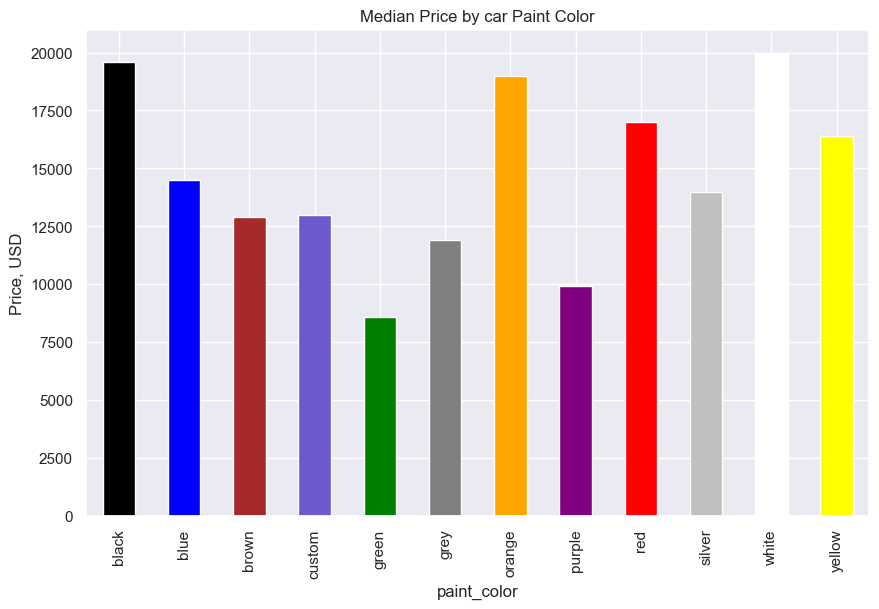

<Figure size 1200x1000 with 0 Axes>

In [272]:
cmap = cm.get_cmap('Spectral') # Colour map
colors = ['black','blue','brown','slateblue','green','grey','orange','purple','red','silver','white','yellow']
df.groupby('paint_color')['price'].median().plot(kind='bar',title='Median Price by car Paint Color', cmap=cmap, color=colors);
plt.ylabel('Price, USD')
plt.figure(figsize=(12, 10))

Higer median car prices for black, white - and surpringly, for orange cars. Then yellow and red come next in the top 5!

In [273]:
pd.crosstab(df['type'],df['paint_color'].isna(), normalize='index').round(2).style.format('{:.2%}')

paint_color,False,True
type,,
SUV,83.00%,17.00%
bus,87.00%,13.00%
convertible,82.00%,18.00%
coupe,86.00%,14.00%
hatchback,83.00%,17.00%
mini-van,84.00%,16.00%
offroad,92.00%,8.00%
other,81.00%,19.00%
pickup,85.00%,15.00%


Black and white median prices are quite similar,though black median price a little less than white's. Therefore I will change missing values in **SUV, convertible, coupe, hatchback, offroad, other, and sedan to black. Black is the most occuring mode there, with a percentage share of 22% and up**. For all those type categories, the other significant paint_color is white. 
**Buses and vans: majority is white, so I will fill missing paint color values with white.**
Other entries with no distinctive conclusion about paint color per type, will be dropped.

In [274]:
df.loc[df["type"] == "SUV", "paint_color"] = df["paint_color"].fillna('black')
df.loc[df["type"] == "convertible", "paint_color"] = df["paint_color"].fillna('black')
df.loc[df["type"] == "coupe", "paint_color"] = df["paint_color"].fillna('black')
df.loc[df["type"] == "hatchback", "paint_color"] = df["paint_color"].fillna('black')
df.loc[df["type"] == "offroad", "paint_color"] = df["paint_color"].fillna('black')
df.loc[df["type"] == "other", "paint_color"] = df["paint_color"].fillna('black')
df.loc[df["type"] == "sedan", "paint_color"] = df["paint_color"].fillna('black')
df.loc[df["type"] == "bus", "paint_color"] = df["paint_color"].fillna('white')
df.loc[df["type"] == "van", "paint_color"] = df["paint_color"].fillna('white')

In [275]:
df.paint_color.isna().mean().round(4)*100

4.44

paint color na percentage droped from over 16% to 4.48%

In [276]:
dropna_subset = ['paint_color']
df.dropna(subset=dropna_subset, inplace=True)
df.paint_color.isna().mean().round(4)*100

0.0

In [277]:
df.isna().mean().round(4)*100

region          0.0
price           0.0
year            0.0
manufacturer    0.0
model           0.0
condition       0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
type            0.0
paint_color     0.0
state           0.0
price_bins      0.0
dtype: float64

## The dataset now does not have any missing values! 🎉

In [278]:
df.shape

(272041, 16)

**After cleaning/filling missing values and removing outliers, the dataset has reduced from over 426,000 entries, to 272,041.**

##  <font color= darkblue> Model Feature: </font>
**Model Feature - has almost 16,000 unique values!(It's over 18,000 models in the original dataset)**

In [279]:
df['model'].nunique()

17580

In [280]:
df['model'].value_counts().nlargest(20)

f-150             4454
silverado 1500    2946
camry             2113
accord            2080
1500              2060
civic             2017
escape            1855
wrangler          1755
altima            1718
grand cherokee    1699
silverado         1644
tacoma            1595
explorer          1566
corolla           1497
mustang           1496
cr-v              1337
2500              1269
equinox           1218
fusion            1217
corvette          1215
Name: model, dtype: int64

In [281]:
df['model'].value_counts().tail()

c/k 3500 series          1
highlander le plus v6    1
envoy/sle 4wd            1
a6 2.7t qu               1
gand wagoneer            1
Name: model, dtype: int64

**Adding Frequency column to the DataFrame, to represent 'model' column in the modeling stage.**
Frequency of occurance per model (frequency = model_value_counts/no_of_entries) instead of model column stirng values, **since model features thousands of different unique car models**. This will give weights for each model type according to its popularity. In that way I avoid making the dataset giganticafter going through OneHotEncoder with lots of unique values for this column.

In [282]:
frequency = df['model'].value_counts()
df['model_frequency'] = df['model'].map(frequency)/(df.shape[0])

In [283]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,price_bins,model_frequency
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al,30k-50k,0.000827
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al,22k-26k,0.010829
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al,30k-50k,0.001647
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al,30k-50k,0.001206
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,14k-18k,0.000801


##  <font color= darkblue> Manufacturer Feature: Exploration and Data Engineering</font>
**manufacturer Feature - has 40 unique values**

In [284]:
df['manufacturer'].value_counts().nunique()

40

In [285]:
df['manufacturer'].value_counts().head(15)

ford             42845
chevrolet        34253
toyota           23138
honda            15025
jeep             12835
nissan           12652
bmw              11251
gmc              10266
ram               9433
dodge             8462
mercedes-benz     8104
hyundai           7194
volkswagen        7119
subaru            6497
lexus             6328
Name: manufacturer, dtype: int64

In [124]:
df2['manufacturer'].value_counts().tail()

fiat               407
harley-davidson     60
ferrari             28
aston-martin        11
land rover           7
Name: manufacturer, dtype: int64

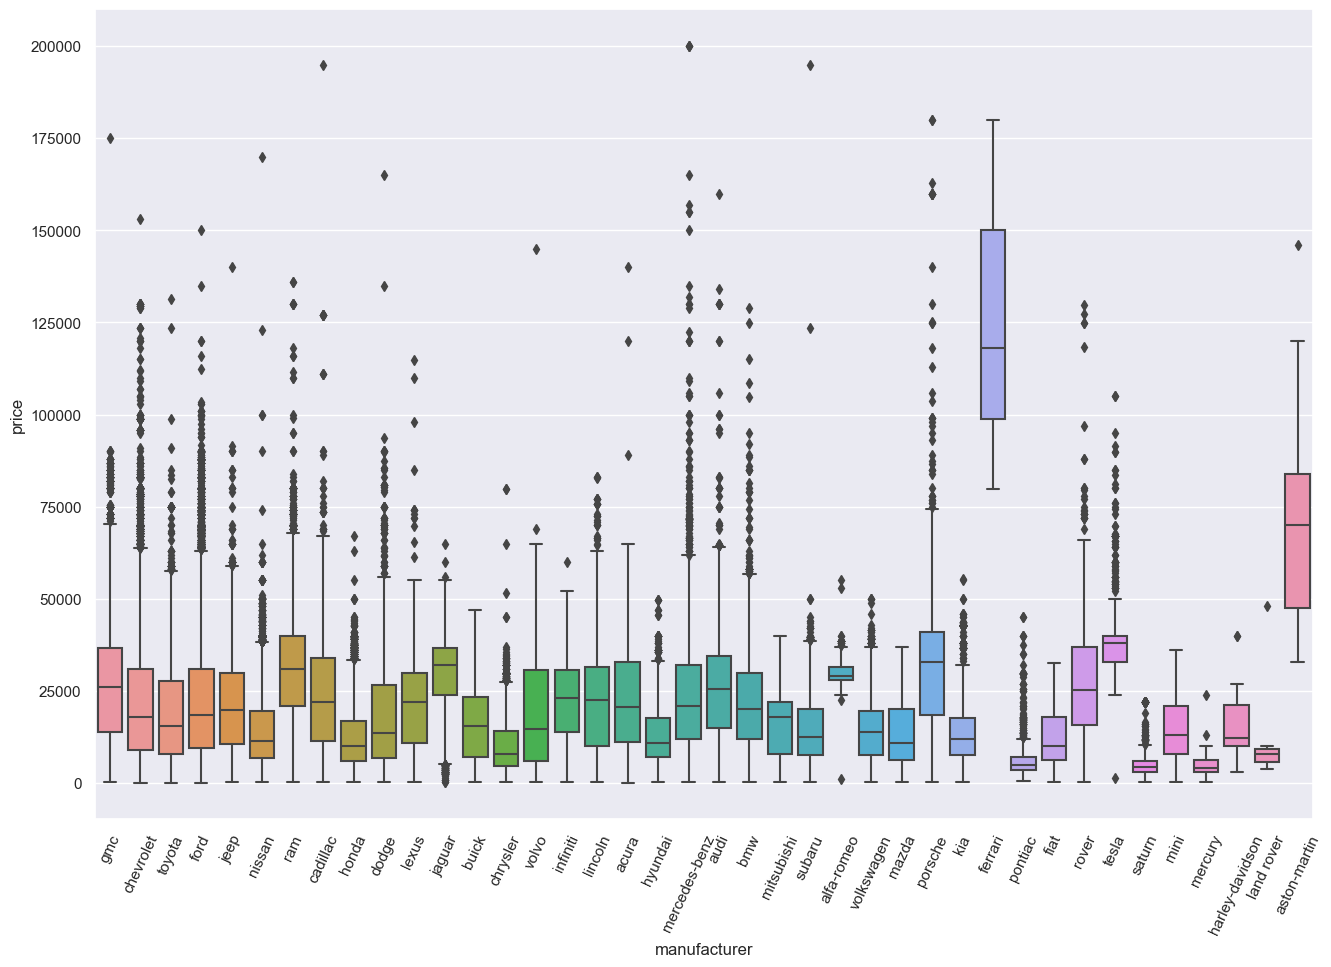

In [129]:
plt.rcParams['figure.figsize'] = 14,10
plt.xticks(rotation=65)
sns.boxplot(data=df2, x='manufacturer', y='price');

There's a unique price range for each manufacturer. Therefore I will use OneHotEncoder to represent each manufacturer.
Ferari and Aston-Martin median prices are way above the others.

##  <font color= darkblue> Region Column: </font>

In [286]:
df['region'].value_counts().nunique()

347

In [287]:
df['region'].value_counts().head()

columbus              2623
jacksonville          2281
sarasota-bradenton    2267
anchorage / mat-su    2267
tucson                2197
Name: region, dtype: int64

In [288]:
df['region'].value_counts().tail()

meridian               11
southwest MS           10
fort smith, AR          7
west virginia (old)     6
kansas city             1
Name: region, dtype: int64

**Dropping region Column:** Region column has high cardinality - 347 unique values. Since region and state features might somehow ovelap,and not to overwhelm the model with too many columns (after going through OneHotEncoder), region feature will be included in the model.

**Checking again for na values before modeling:**

In [312]:
df.isna().sum()

region             0
price              0
year               4
manufacturer       0
model              0
condition          0
cylinders          0
fuel               0
odometer           0
title_status       0
transmission       0
drive              0
type               0
paint_color        0
state              0
model_frequency    0
dtype: int64

In [315]:
df.dropna(inplace=True)

#  <font color= darkblue> Prepare Data for Modeling </font>

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272041 entries, 27 to 426879
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   region           272041 non-null  object  
 1   price            272041 non-null  int64   
 2   year             272037 non-null  float64 
 3   manufacturer     272041 non-null  object  
 4   model            272041 non-null  object  
 5   condition        272041 non-null  object  
 6   cylinders        272041 non-null  object  
 7   fuel             272041 non-null  object  
 8   odometer         272041 non-null  float64 
 9   title_status     272041 non-null  object  
 10  transmission     272041 non-null  object  
 11  drive            272041 non-null  object  
 12  type             272041 non-null  object  
 13  paint_color      272041 non-null  object  
 14  state            272041 non-null  object  
 15  price_bins       272041 non-null  category
 16  model_frequency  27

In [294]:
# Dropping price_bins column, was created  for data ispection
df.drop(columns=['price_bins'], axis=1, inplace=True)

In [316]:
# Columns that will not go into the model: model (car model, 17580 unique values), and region.
X = df.drop(['price','model','region'], axis=1)
y = df['price']

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [318]:
X.columns

Index(['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state',
       'model_frequency'],
      dtype='object')

In [299]:
categorical_cols = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 
                    'drive', 'type', 'state', 'paint_color']
numeric_cols = ['odometer', 'year','model_frequency']

cat_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])
num_pipeline = Pipeline([
    ('standard_scaler', StandardScaler())
])

In [302]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])

#  <font color= blue> Modeling </font>

**Model is Multiple Regresion, base on LinearRegression (multiple Features)**

In [303]:
model = LinearRegression()

In [304]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

**GridSearchCV, estimator = LinearRegression.**

The scoring method I'm using is Mean Absolute Error (MAE). It is a good scoring method for multiple regression with nueric target, in order to reduce predictions error.

In [309]:
params = {
    'model__fit_intercept': [True, False],
    'model__normalize': [True, False]
}

In [327]:
grid_search = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5)

In [328]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standard_scaler',
                                                                                          StandardScaler())]),
                                                                         ['odometer',
                                                                          'year',
                                                                          'model_frequency']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('one_hot_encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                        

## Model Evaluation

In [329]:
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print('Multiple Regression GridSearch, Test score: ', test_score)

Multiple Regression GridSearch, Test score:  0.5037343059650847


In [330]:
train_score = best_model.score(X_train, y_train)
print('Multiple Regression GridSearch, Train score: ', train_score)

Multiple Regression GridSearch, Train score:  0.5171994752646245


In [331]:
best_params_lin = grid_search.best_params_
print('Multiple Regression GridSearchCV best params: ', best_params_lin)

Multiple Regression GridSearchCV best params:  {'model__fit_intercept': False, 'model__normalize': True}


## Get Model Coefficients

In [339]:
preprocessor_best = best_model.named_steps['preprocessor']
cat_encoder = preprocessor_best.named_transformers_['cat']
cat_onehot_cols = cat_encoder.get_feature_names_out(categorical_cols)
num_cols = numeric_cols

coef_names = list(cat_onehot_cols) + num_cols
coef_values = best_model.named_steps['model'].coef_
#coef_values = best_model.named_steps['model'].coef_.reshape(1, -1)

coef_data = {'Coef name': coef_names, 'value': coef_values}
coef_df = pd.DataFrame(coef_data)

coef_df

,Coef name,value
0,manufacturer_acura,-1795.265471
1,manufacturer_alfa-romeo,5145.716097
2,manufacturer_aston-martin,-341.530413
3,manufacturer_audi,-1514.521817
4,manufacturer_bmw,3335.860551
...,...,...
146,paint_color_white,2132.923604
147,paint_color_yellow,1399.328498
148,odometer,63.066499
149,year,1524.724073


In [351]:
coef_df_sorted = coef_df.reindex(coef_df['value'].abs().sort_values(ascending=False).index)

In [353]:
coef_df_sorted.head(20)

,Coef name,value
14,manufacturer_gmc,81779.720240
5,manufacturer_buick,22680.381392
40,manufacturer_volvo,13919.508798
12,manufacturer_fiat,13809.978180
48,cylinders_12 cylinders,13062.256464
58,fuel_hybrid,12541.242305
15,manufacturer_harley-davidson,-10749.557209
35,manufacturer_saturn,10329.357344
71,drive_rwd,8924.087335
18,manufacturer_infiniti,-8819.676433


## Multiple Regression Model Findings:
**According to the top 10 important coefficients (highest coef. values), top ten factprs that infulence a used car price are:**

1. manufacturer_gmc
2. manufacturer_buick
3. manufacturer_volvo
4. manufacturer_fiat
5. cylinders_12 cylinders
6. fuel_hybrid
7. manufacturer_saturn
8. drive_rwd
9. type_SUV
10. title_status_salvage

**Top features to increase a used car price (inverse relation)**

1. manufacturer_harley-davidson
2. manufacturer_infiniti
3. manufacturer_toyota
4. manufacturer_porsche
5. manufacturer_lincoln
6. manufacturer_ferrari
7. manufacturer_jeep

In [345]:
coef_df_sorted.tail(10)

,Coef name,value
97,state_ia,123.182004
96,state_hi,-109.612725
106,state_me,-105.047703
138,paint_color_brown,100.402324
124,state_ri,-77.643461
98,state_id,68.894474
148,odometer,63.066499
27,manufacturer_mercury,29.060169
116,state_nj,25.055158
105,state_md,10.494021


## Fit the model on Log(y):

In [346]:
y_train_log = np.log(y_train)

logY_grid = GridSearchCV(estimator=pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV object on the training data with log(target)
logY_grid.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standard_scaler',
                                                                                          StandardScaler())]),
                                                                         ['odometer',
                                                                          'year',
                                                                          'model_frequency']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('one_hot_encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                        

### Log(Target) Model Evaluation

In [348]:
y_test_log = np.log(y_test)
best_model_log = logY_grid.best_estimator_
test_score_log = best_model_log.score(X_test, y_test_log)
print('Multiple Regression GridSearch, Log(Target), Test score: ', test_score)

Multiple Regression GridSearch, Log(Target), Test score:  0.5037343059650847


MSE for fitting the model on Log(y) gives the same mse.

# Summary and Findings

The multiple regression model was found to have a very good predictive power, with a small Test set MSE of 0.5037. 
Out of all the various features of a used car, such as year manufactured, odometer read, paint color,manufacturer, condition, number of cylinders, fuel type, drive, and type, the most influential on car price were a few car manufacturers. Out of top 10 factors that increases a used car price, top 4 were manufacturers. Other features of used car that has a lot of influence on its price are: cylinders_12 cylinders, fuel_hybrid, manufacturer_saturn, drive_rwd, type_SUV, and title_status: salvage.

Top 4 manufacturers to increase a used car price: manufacturer_gmc, manufacturer_buick, manufacturer_volvo, manufacturer_fiat.

Top 7 features that inversely affect a used car price: manufacturer_harley-davidson
manufacturer_harley-davidson
manufacturer_infiniti
manufacturer_toyota
manufacturer_porsche
manufacturer_lincoln
manufacturer_ferrari
manufacturer_jeep

My reccomendation for car dealers is to look out after market demand and find those car brands in high demands to get better sales. GMC, Buick, Volvo, and Fiat seem like a sought after car brands.


# Next Steps

This model together with its data preparation methods are not done yet. I recommend to further explore how treating missing values differently, and including the model feature as a category can change the model predictions and features importance.
I also recommend to explore how leaving out outliers like very old cars (cars older than 25 years) can influence the model predictive power. Used car 25 years old and under are the majority of the market, and very old/antique cars might have rules of their own.